In [4]:
!pip install bitarray

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.7/272.7 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import bitarray

In [7]:
charlist = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"," ","$","%","*","+","-",".","/",":"]
global charlist
errorlevels = ["L","M","Q","H"]
modes = ["0001","0010","0100"] #numeric, alphanumeric, binary

#how many data bytes for each version (level L,M,Q,H) (limited to just ones with 1 group)
datalengths = [[0,19,34,55,80,108],
               [0,16,28,44],
               [0,13,22],
               [0, 9,16]]

errorlengths = [[0,7,10,15,20,26],
                [0,10,16,26],
                [0,13,22],
                [0,17,28]]



def cclengths(V):
    if V <= 9:
        return [10,9,8]
    elif V <= 26:
        return [12,11,16]
    else:
        return [14,13,16]

def Plot(matrix,padding = False):
    ratio = matrix.shape[1]/matrix.shape[0]
    plt.figure(figsize=(8*ratio,8))
    plt.xlim(-4*padding,matrix.shape[1]+4*padding)
    plt.ylim(-4*padding,matrix.shape[0]+4*padding)
    ax = plt.gca()
    for i in range(matrix.shape[1]):
        for j in range(matrix.shape[0]):
            if matrix[j,i]:
                ax.add_patch(plt.Rectangle((i,len(matrix)-1-j),1,1,color = 'black'))
    plt.show()
    
def mask(x,y,N,method = 0):
        return [(x+y)%2 == 0, y%2 == 0, x % 3 == 0, (x+y)%3 == 0, (y//2 + x//3) % 2 == 0, (x*y)%2 + (x*y)%3 == 0, ((x*y)%2 + (x*y)%3)%2 == 0, ((x+y)%2 + (x*y)%3)%2 == 0 ][method] if maskcheck(x,y,N) else 0   
    
def maskcheck(x,y,N):
    if N < 22:
        return (y <= 8 and x >= 9 and x < N-8 and y != 6) or (x <= 8 and x != 6 and y > 8 and y < N-8) or (x>8 and y > 8)
    else:
        return ((y <= 8 and x >= 9 and x < N-8 and y != 6) or (x <= 8 and x != 6 and y > 8 and y < N-8) or (x>8 and y > 8)) and not (x >= N - 9 and x <= N - 5 and y >= N - 9 and y <= N - 5 )
    
    
    
#alphanumaric mode exclusive content
def alphaencoder(message):
    global charlist
    encoded = []
    message = message.upper()
    for i in range(len(message)//2):
        c1 = charlist.index(message[2*i])
        c2 = charlist.index(message[2*i+1])
        encoded += [45*c1 + c2]
    encbin = "".join(["0"*(11-len(str(bin(e))[2:]))+str(bin(e))[2:] for e in encoded])
    if len(message)%2 == 1:
        encbin += "0"*(6-len(str(bin(charlist.index(message[-1])))[2:]))+str(bin(charlist.index(message[-1])))[2:]
    return encbin

def byteencoder(message):
    pass
#lets make the power talbe of the Galois Field GF(256) real quick
#"real quick" she said -.-
GF = [1]
for i in range(1,256):
    if 2*GF[-1] < 256:
        GF.append(2*GF[-1])
    else:
        GF.append(2*GF[-1]^285)

#this is probably needed later
global GF

mult = lambda a,b: GF[(GF.index(a) + GF.index(b))%255] if a != 0 and b != 0 else 0
add = lambda a,b: a^b

#multiplying polynomials
def polymult(l1,l2):
    #inputs are lists with coefficients of x^n ... x^0
    #reverse the lists
    rl1 = l1[::-1]
    rl2 = l2[::-1]
    routput = [0]*2*max(len(l1),len(l2))
    for index1,num1 in enumerate(rl1):
        for index2,num2 in enumerate(rl2):
            routput[index1+index2] = add(routput[index1+index2],mult(num1,num2))
    #unreverse the list
    output = routput[::-1]
    #delete any leading zeros
    while output != [] and output[0] == 0:
        output.pop(0)
    return output
        
def polydivide(message,generator): #we want to divide message by gen
    gen = generator.copy()
    n = len(gen)-1 # 7
    #multiply the message by x^7
    remainder = message.copy()
    remainder += [0]*n
    gen += [0]*(len(remainder)-len(generator))
    while(len(remainder) > n):
        remainder = [add(remainder[i],polymult([remainder[0]],gen)[i]) for i in range(len(remainder))]
        gen.pop(-1) #divide by x
        while remainder != [] and remainder[0] == 0: #remove leading zeros
            remainder.pop(0)
    return remainder

def place(matrix,x,y,N,placed,fullbin):
    if maskcheck(x,y,N):
        matrix[y, x] = fullbin[placed] if placed < len(fullbin) else 0
        placed += 1
    return matrix,placed

def lenscore(n):
    return n-2 if n>=5 else 0

def skillcheck(matrix): #this assumes a square matrix
    scorelist = [0,0,0,0]
    N = matrix.shape[0]
    
    #horizontal streak score
    for y in range(N):
        for x in range(N):
            if x == 0 or matrix[y,x] != current or x == N-1:
                if x != 0:
                    scorelist[0] += lenscore(streak)
                streak = 1
                current = matrix[y,x]
            elif matrix[y,x] == current:
                streak += 1
    
    #vertical streak score
    for x in range(N):
        for y in range(N):
            if y == 0 or matrix[y,x] != current or y == N-1:
                if y != 0:
                    scorelist[0] += lenscore(streak)
                streak = 1
                current = matrix[y,x]
            elif matrix[y,x] == current:
                streak += 1    
    
    #box score
    for y in range(N-1):
        for x in range(N-1):
            if matrix[y,x] == matrix[y+1,x] == matrix[y,x+1] == matrix[y+1,x+1]:
                scorelist[1] += 3
    
    #dldddldllll score
    for x in range(N-10):
        for y in range(N-10):
            if [matrix[y,x+p] for p in range(11)] == [1,0,1,1,1,0,1,0,0,0,0] or [matrix[y,x+p] for p in range(11)] == [0,0,0,0,1,0,1,1,1,0,1]:
                scorelist[2] += 40
            if [matrix[y+p,x] for p in range(11)] == [1,0,1,1,1,0,1,0,0,0,0] or [matrix[y+p,x] for p in range(11)] == [0,0,0,0,1,0,1,1,1,0,1]:
                scorelist[2] += 40
    
    totalsquares = N*N
    blacksquares = sum(np.transpose(sum(matrix)))[0,0]
    percentage = blacksquares/totalsquares*100
    next5,prev5 = np.abs(np.ceil(percentage/5)) - 10,np.abs(np.floor(percentage/5) - 10)
    scorelist[3] += 10*min(next5,prev5)
            
    
    return scorelist


def modecheck(text):
    text = str(text)
    if sum([letter not in [str(i) for i in range(10)] for letter in text]) == 0:
        return 0 #numeric
    global charlist
    if sum([letter not in charlist for letter in text]) == 0:
        return 1 #alphanumeric
    else:
        return 2 #binary


#print(modecheck("DA"))
#print(skillcheck(matrix))
smallblock = np.matrix([[1,1,1,1,1],
              [1,0,0,0,1],
              [1,0,1,0,1],
              [1,0,0,0,1],
              [1,1,1,1,1]])
bigblock = np.matrix([[1,1,1,1,1,1,1],
            [1,0,0,0,0,0,1],
            [1,0,1,1,1,0,1],
            [1,0,1,1,1,0,1],
            [1,0,1,1,1,0,1],
            [1,0,0,0,0,0,1],
            [1,1,1,1,1,1,1]])

def numencoder(num):
    numlist = [str(num)[3*i:3*i+3] for i in range(len(str(num))//3)] 
    if len(str(num)) % 3 != 0:
        numlist.append(str(num)[-(len(str(num)) % 3):])
    lengths = [0,4,7,10]
    binnumlist = ["0"*(lengths[len(a)]-len(str(bin(int(a)))[2:])) + str(bin(int(a)))[2:] for a in numlist]
    return "".join(binnumlist)
    
    
def byteencoder(message):
    message = str(message)
    ba = bitarray.bitarray()
    ba.frombytes(message.encode('latin_1'))
    return "".join([str(int(i)) for i in ba])
encoders = [numencoder,alphaencoder,byteencoder]
    

Message is 12 characters
The max data length is 19
Data is 14 bytes
The message polynomial has coefficients: [64, 197, 71, 38, 22, 231, 50, 7, 38, 150, 118, 135, 71, 48, 236, 17, 236, 17, 236]
The generator polynomial has coefficients: [1, 127, 122, 154, 164, 11, 68, 117]
The error codewords are: [122, 216, 69, 197, 106, 165, 23]
I sure hope the QR code has 208 maskable squares.
Wouldn't you know it there were 208
Scores rangd from 388.0 to 535.0
[443.0, 440.0, 516.0, 516.0, 388.0, 535.0, 496.0, 443.0]
I was a big fan of mask 4


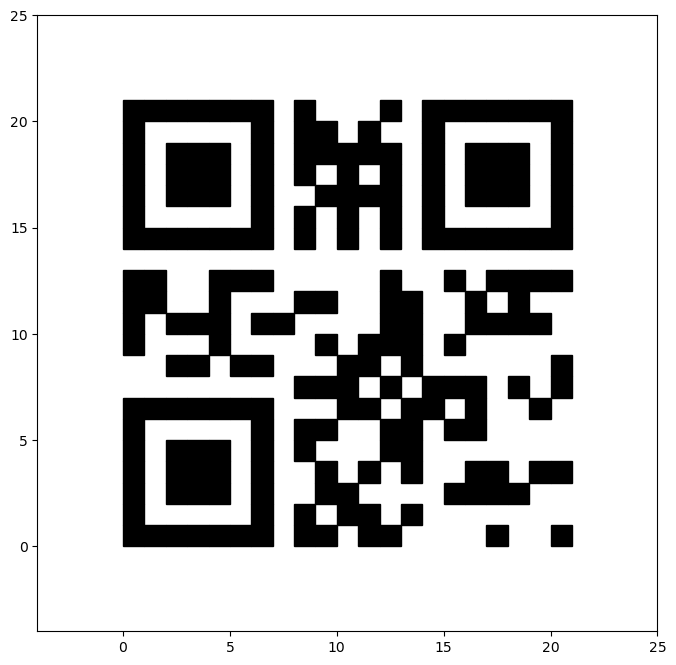

In [10]:
def QRGEN(text,V,errorlevel):

    #text = "yup"
    #errorlevel = 2
    print("Message is",len(text),"characters")
    #V = 1
    N = 4*V+17
    matrix = np.matrix(np.zeros((N,N)))

    #CORNERS
    matrix[:8,:8] = np.zeros((8,8))
    matrix[:7,:7] = bigblock
    matrix[:8,-8:] = np.zeros((8,8))
    matrix[:7,-7:] = bigblock
    matrix[-8:,:8] = np.zeros((8,8))
    matrix[-7:,:7] = bigblock

    # TIMING
    matrix[6,8:-8] = [1] + [0,1]*2*V
    matrix[8:-8,6] = [[1]] + [[0],[1]]*2*V

    # one specific pixel
    matrix[-8,8] = 1
    
    #bottom right block for versions 2 to 6 (this code only covers up to version 5)
    if V > 1:
        matrix[-9:-4,-9:-4] = smallblock
    

    #alphanumeric mode: 0010
    mode = modecheck(text)
    charcount = len(text)
    #version 1 alphanumeric: length is 9 bits (QR spec, version and mode dependent)
    cclength = cclengths(V)[mode]
    ccbinary = "0"*(cclength-len(str(bin(charcount))[2:]))+str(bin(charcount))[2:]
    #print(modes[mode], ccbinary,encoders[mode](text))
    encoded = modes[mode] + ccbinary + encoders[mode](text)
    datalength = len(encoded)
    maxdatalength = datalengths[errorlevel][V]
    print("The max data length is",maxdatalength)


    print("Data is",int(np.ceil(datalength/8)),"bytes")
    #pad with zeros (2 steps)
    if len(encoded) > maxdatalength*8:
        print("ERROR: TEXT TOO LONG")
        return
    encoded += max(4,len(encoded) - maxdatalength*8)*"0"
    if len(encoded)%8 != 0:
        encoded += (8-len(encoded)%8)*"0"
    #pad with 17 and 236 (QR spec)
    i17 = 0
    while len(encoded) < maxdatalength*8:
        if i17%2 == 0:
            encoded += "11101100"
        else:
            encoded += "00010001"
        i17 += 1
    #split into bytes, maxdatalength is version and error correction dependent
    message = [int(encoded[8*i:8*i+8],2) for i in range(maxdatalength)]
    print("The message polynomial has coefficients:",message)

    # \begin{Galois}
    global GF
    n = errorlengths[errorlevel][V] #number of error correction codewords for 1-L (QR spec, version and error correction dependent)
    generator = [1] #polynomial of y = 1
    for i in range(n):
        generator = polymult(generator,[GF[0],GF[i]])
    #print([GF.index(g) for g in generator]) #powers of alpha
    print("The generator polynomial has coefficients:",generator)
    errorcodes = polydivide(message,generator)
    print("The error codewords are:",errorcodes)
    # \end{Galois} 

    #this is a simplification of the 2 block error interleving... thing, which is fine for smaller codes
    fullbin = "".join(["0"*(8-len(str(bin(e))[2:]))+str(bin(e))[2:] for e in (message+errorcodes)])
    print("I sure hope the QR code has",len(fullbin),"maskable squares.")
    # print(fullbin)

    pointer = [N-1,N-1] #here we go...
    # pointer = [20,8]
    placed = 0

    while pointer[1] >= 0:
        while pointer[0] >= 0:
            matrix,placed = place(matrix,pointer[1],pointer[0],N,placed,fullbin)
            pointer[1] -= 1
            matrix,placed = place(matrix,pointer[1],pointer[0],N,placed,fullbin)
            pointer[0] -= 1
            pointer[1] += 1
        pointer[1] -= 2
        if pointer[1] == 6:
            pointer[1] -= 1
        pointer[0] += 1
        if pointer[1] < 0:
            break
        while pointer[0] < N:
            matrix,placed = place(matrix,pointer[1],pointer[0],N,placed,fullbin)
            pointer[1] -= 1
            matrix,placed = place(matrix,pointer[1],pointer[0],N,placed,fullbin)
            pointer[0] += 1
            pointer[1] += 1
        pointer[1] -= 2
        pointer[0] -= 1
    print("Wouldn't you know it there were",placed)
    # Plot(matrix)

    #masking
    testmatrices = []
    scores = []
    for method in range(8):
        newmat = matrix.copy()
        for x in range(N):
            for y in range(N):
                newmat[y,x] = 1 - newmat[y,x] if mask(x,y,N,method) else newmat[y,x]
        scores.append(sum(skillcheck(newmat)))        
        testmatrices.append(newmat)
        # Plot(newmat)
    print(f"Scores rangd from {min(scores)} to {max(scores)}")
    print(scores)
    maskchoice = scores.index(min(scores))
    print("I was a big fan of mask",maskchoice)
    matrix = testmatrices[maskchoice]

    #format bit, todo derive this manually
    formats = [[ "111011111000100", "111001011110011", "111110110101010", "111100010011101", "110011000101111", "110001100011000", "110110001000001","110100101110110"],       
               [ "101010000010010", "101000100100101", "101111001111100", "101101101001011", "100010111111001", "100000011001110", "100111110010111", "100101010100000"],
               [ "011010101011111", "011000001101000", "011111100110001", "011101000000110", "010010010110100", "010000110000011", "010111011011010", "010101111101101"],
               [ "001011010001001", "001001110111110", "001110011100111", "001100111010000", "000011101100010", "000001001010101", "000110100001100", "000100000111011"]] 
    formatbin = formats[errorlevel][maskchoice]
    pointerlist1 = [[8,0],[8,1],[8,2],[8,3],[8,4],[8,5],[8,7],[8,8],[7,8],[5,8],[4,8],[3,8],[2,8],[1,8],[0,8]]
    pointerlist2 = [[N-1,8],[N-2,8],[N-3,8],[N-4,8],[N-5,8],[N-6,8],[N-7,8],[8,N-8],[8,N-7],[8,N-6],[8,N-5],[8,N-4],[8,N-3],[8,N-2],[8,N-1]]  
    for i,point in enumerate(pointerlist1):
        matrix[point[0],point[1]] = int(formatbin[i])
    for i,point in enumerate(pointerlist2):
        matrix[point[0],point[1]] = int(formatbin[i])



    Plot(matrix,True)
QRGEN("Trans rights",1,0) 
